In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as stats
import seaborn as sea
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Import data
income = pd.read_excel('Census_median_income_1984_2019.ods', engine='odf',header=[59])
president = pd.read_csv('1976-2016-president.csv')


# Merge and reset index to create main dataframe
president_income = president.merge(income, left_on='state', right_on='State', how='left')
president_income = president_income.reset_index().set_index(['year','state'])


# Isolate [year] Median Income and [year] Standard Error data
median_col = income.columns.str.contains('Median')
Median_Income = income.iloc[:,median_col]
error_col = income.columns.str.contains('Error')
Standard_Error = income.iloc[:,error_col]


# Change Median and Error data to have 'State', 'year', and Median/Error in specified columns
median = pd.melt(income, id_vars='State',value_vars=income.columns[median_col],var_name='year')
error = pd.melt(income, id_vars='State',value_vars=income.columns[error_col],var_name='year')


# Edit column names to match data change above
median['year'] = median['year'].str.replace('Median Income','')
median = median.rename(columns = {'value':'Median Income'})
error['year'] = error['year'].str.replace('Standard Error','')
error = error.rename(columns = {'value':'Standard Error'})


#Edit 'State' to match 'state' in main dataframe
median = median.rename(columns = {'State':'state'})
error = error.rename(columns = {'State':'state'})

median['year'] = pd.to_numeric(median['year'])
error['year'] = pd.to_numeric(median['year'])

median = median.set_index(['year','state'])
error = error.set_index(['year','state'])

president_income = president_income.reset_index()
politics = president_income[['year','state','office','candidate', 'party', 'writein', 'candidatevotes', 'totalvotes']].copy()

median = median.reset_index()
error = error.reset_index()


# Merge Median Income and Standard Error columns into main dataframe
income_politics_table = politics.merge(median, on=['year','state'], how='outer')
income_politics_table = income_politics_table.merge(error, on=['year','state'], how='outer')
ipt = income_politics_table

# Export Dataframe as excel sheet to confirm expectations
ipt.to_excel(r'\politcal_excel.xlsx', index = False)

p_value = []
d_table = []


max_v = ipt.groupby(['year', 'state'])['candidatevotes'].transform(func=max)


state_winning_party = ipt[ipt['candidatevotes']==max_v]


median_income_state = state_winning_party.groupby('year').mean()['Median Income']
democrat = state_winning_party[state_winning_party['party'] == 'democrat']
democrat_median_income = democrat['Median Income']
republican = state_winning_party[state_winning_party['party'] == 'republican']
republican_median_income = republican['Median Income']

In [2]:
state_winning_party

,year,state,office,candidate,party,writein,candidatevotes,totalvotes,Median Income,Standard Error
0,1976,Alabama,US President,"Carter, Jimmy",democrat,False,659170.0,1182850.0,NaN,NaN
7,1976,Alaska,US President,"Ford, Gerald",republican,False,71555.0,123574.0,NaN,NaN
11,1976,Arizona,US President,"Ford, Gerald",republican,False,418642.0,742719.0,NaN,NaN
19,1976,Arkansas,US President,"Carter, Jimmy",democrat,False,498604.0,767535.0,NaN,NaN
23,1976,California,US President,"Ford, Gerald",republican,False,3882244.0,7803770.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3704,2016,Virginia,US President,"Clinton, Hillary",democrat,False,1981473.0,3982752.0,70795.0,2595.0
3710,2016,Washington,US President,"Clinton, Hillary",democrat,False,1742718.0,3317019.0,74906.0,2229.0
3718,2016,West Virginia,US President,"Trump, Donald J.",republican,False,489371.0,713051.0,47253.0,2124.0
3723,2016,Wisconsin,US President,"Trump, Donald J.",republican,False,1405284.0,2976150.0,63727.0,1966.0


In [3]:
# Limit Dataframe to just data where everything is complete
winning_party_full_data = state_winning_party.loc[state_winning_party['year'].between(1984,2016) & state_winning_party['office'] == True]

In [4]:
winning_party_full_data

,year,state,office,candidate,party,writein,candidatevotes,totalvotes,Median Income,Standard Error
696,1984,Alabama,US President,"Reagan, Ronald",republican,False,872849.0,1441713.0,40682.0,1422.0
703,1984,Alaska,US President,"Reagan, Ronald",republican,False,138377.0,207605.0,76043.0,3462.0
707,1984,Arizona,US President,"Reagan, Ronald",republican,False,681416.0,1025897.0,50353.0,1431.0
711,1984,Arkansas,US President,"Reagan, Ronald",republican,False,534774.0,884406.0,36837.0,1758.0
721,1984,California,US President,"Reagan, Ronald",republican,False,5467009.0,9505041.0,59429.0,855.0
...,...,...,...,...,...,...,...,...,...,...
3704,2016,Virginia,US President,"Clinton, Hillary",democrat,False,1981473.0,3982752.0,70795.0,2595.0
3710,2016,Washington,US President,"Clinton, Hillary",democrat,False,1742718.0,3317019.0,74906.0,2229.0
3718,2016,West Virginia,US President,"Trump, Donald J.",republican,False,489371.0,713051.0,47253.0,2124.0
3723,2016,Wisconsin,US President,"Trump, Donald J.",republican,False,1405284.0,2976150.0,63727.0,1966.0


In [41]:
winning_party_full_data.replace('republican', 0, inplace=True)
winning_party_full_data.replace('democrat', 1, inplace=True)
winning_party_full_data

/home/wbeedle/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,year,state,office,candidate,party,writein,candidatevotes,totalvotes,Median Income,Standard Error
696,1984,Alabama,US President,"Reagan, Ronald",0,False,872849.0,1441713.0,40682.0,1422.0
703,1984,Alaska,US President,"Reagan, Ronald",0,False,138377.0,207605.0,76043.0,3462.0
707,1984,Arizona,US President,"Reagan, Ronald",0,False,681416.0,1025897.0,50353.0,1431.0
711,1984,Arkansas,US President,"Reagan, Ronald",0,False,534774.0,884406.0,36837.0,1758.0
721,1984,California,US President,"Reagan, Ronald",0,False,5467009.0,9505041.0,59429.0,855.0
...,...,...,...,...,...,...,...,...,...,...
3704,2016,Virginia,US President,"Clinton, Hillary",1,False,1981473.0,3982752.0,70795.0,2595.0
3710,2016,Washington,US President,"Clinton, Hillary",1,False,1742718.0,3317019.0,74906.0,2229.0
3718,2016,West Virginia,US President,"Trump, Donald J.",0,False,489371.0,713051.0,47253.0,2124.0
3723,2016,Wisconsin,US President,"Trump, Donald J.",0,False,1405284.0,2976150.0,63727.0,1966.0


/home/wbeedle/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

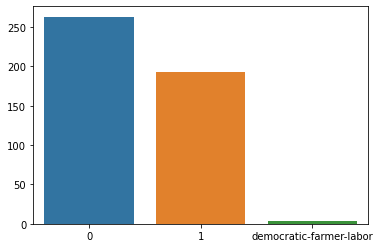

In [48]:
# values = list(range(len(winning_party_full_data.index)))
# party = pd.DataFrame(winning_party_full_data['party'])
# party
probabilities = winning_party_full_data['party'].value_counts()    
sea.barplot(probabilities.index, probabilities.values)

In [22]:
winning_party_full_data.index

Int64Index([ 696,  703,  707,  711,  721,  726,  734,  739,  745,  754,
            ...
            3676, 3680, 3684, 3689, 3695, 3704, 3710, 3718, 3723, 3732],
           dtype='int64', length=459)

In [6]:
party_data = winning_party_full_data

In [7]:
# Split Data into Train, Test, and Validation Set
party_data_validation = party_data
# party_data = party_data[party_data['year'] <= 1999]
X = pd.DataFrame(party_data, columns=party_data.columns)
X.drop(['office', 'candidate', 'party', 'state', 'year', 'Standard Error', 'writein'], axis=1, inplace=True)
y = pd.Series(party_data['party'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [8]:
X

,candidatevotes,totalvotes,Median Income
696,872849.0,1441713.0,40682.0
703,138377.0,207605.0,76043.0
707,681416.0,1025897.0,50353.0
711,534774.0,884406.0,36837.0
721,5467009.0,9505041.0,59429.0
...,...,...,...
3704,1981473.0,3982752.0,70795.0
3710,1742718.0,3317019.0,74906.0
3718,489371.0,713051.0,47253.0
3723,1405284.0,2976150.0,63727.0


In [9]:
rf = RandomForestClassifier(n_estimators=2000,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)

# print(f"mean squared error = {mean_squared_error(X_train, X_test)}")
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")

print(f"accuracy = {rf.score(X_test, y_test)}")


# find the correlation between real answer and prediction
correlation = round(rf.score(X_test, y_test))

output_filename = "rf_regression.png"
title_name = "Random Forest Regression - State Vote vs Predicted Vote - correlation ({})".format(correlation)
x_axis_label = "State Vote"
y_axis_label = "Predicted Vote"
 
# plot data
(X_test, pred, output_filename, title_name, x_axis_label, y_axis_label)


accuracy = 0.7028985507246377


(      candidatevotes  totalvotes  Median Income
 3098       7854285.0  13038547.0        63609.0
 825        1310936.0   2559383.0        63359.0
 1876        363467.0    677415.0        55366.0
 2654        259760.0    437134.0        65036.0
 1780       1006693.0   2135431.0        57211.0
 ...              ...         ...            ...
 2147        638517.0   1353022.0        61025.0
 1247        606443.0    986009.0        53200.0
 2918        452979.0    801281.0        60383.0
 3302       2827621.0   5580822.0        49503.0
 1930       2148222.0   4534434.0        55458.0
 
 [138 rows x 3 columns],
 array(['democrat', 'democrat', 'republican', 'democrat', 'democrat',
        'republican', 'republican', 'republican', 'republican',
        'republican', 'republican', 'republican', 'republican',
        'republican', 'republican', 'democrat', 'republican', 'republican',
        'democrat', 'republican', 'republican', 'democrat', 'republican',
        'democrat', 'republican', 're

In [10]:
con= confusion_matrix(y_test,pred)
con

array([[36,  0, 28],
       [ 1,  0,  0],
       [12,  0, 61]])

<AxesSubplot:>

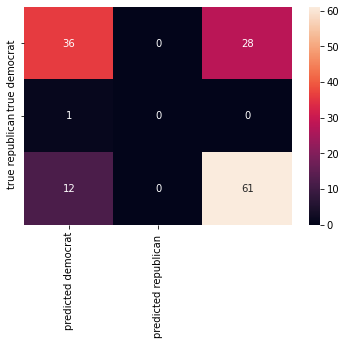

In [11]:
sea.heatmap(con,xticklabels=['predicted democrat', 'predicted republican '],yticklabels=['true democrat', 'true republican'], annot=True)

In [12]:
y_test


3098      democrat
825     republican
1876    republican
2654      democrat
1780    republican
           ...    
2147      democrat
1247    republican
2918    republican
3302      democrat
1930      democrat
Name: party, Length: 138, dtype: object

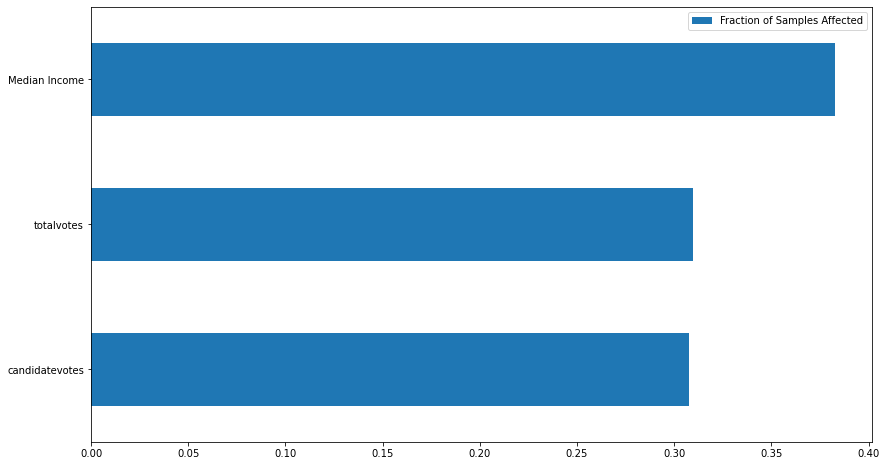

In [13]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize = (14,8));

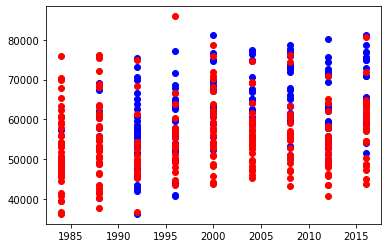

In [14]:
# Scatterplot of Data
fig, ax = plt.subplots()
ax.scatter(democrat.iloc[:,0],democrat_median_income,c='blue')
ax.scatter(republican.iloc[:,0],republican_median_income,c='red')

In [15]:

X = pd.DataFrame(party_data_validation, columns=party_data_validation.columns)
X.drop(['Standard Error', 'office', 'candidate', 'writein', 'party', 'state', 'year'], axis=1, inplace=True)
y = pd.Series(party_data_validation['party'])

pred = rf.predict(party_data_validation['party'])
print(f"log loss = {log_loss(y, rf.predict_proba(win_with_dummies_validation)[:, 1])}")
print(f"accuracy = {rf.score(win_with_dummies_validation, y)}")

ValueError: could not convert string to float: 'republican'